# Simple MAD

This notebook shows the simplest possible MAD: a two pixel image, where our models are L2-norm and L1-norm. It will not explain the basics of MAD Competition or how to use it. Instead, since we're dealing with a simple and low-dimensional example, we can plot the image in pixel space and draw out the model contours, which we can use to explicitly check whether we've found the correct results.

In [1]:
import plenoptic as po
from plenoptic.tools import to_numpy
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np
import itertools

%load_ext autoreload
%autoreload 2

First we pick our metrics and run our synthesis. We create four different `MADCompetition` instances, in order to create the full set of images.

In [2]:
img = torch.tensor([.5, .5], dtype=torch.float32).reshape((1, 1, 1, 2))
def l1_norm(x, y):
    return torch.norm(x-y, 1)
metrics = [po.tools.optim.l2_norm, l1_norm]
all_mad = {}

# this gets us all four possibilities
for t, (m1, m2) in itertools.product(['min', 'max'], zip(metrics, metrics[::-1])):
    name = f'{m1.__name__}_{t}'
    # we set the seed like this to ensure that all four MADCompetition instances have the same initial_signal. Try different seed values! 
    po.tools.set_seed(160)
    all_mad[name] = po.synth.MADCompetition(img, m1, m2, t, metric_tradeoff_lambda=1e4)
    optim = torch.optim.Adam([all_mad[name].synthesized_signal], lr=.0001)
    print(f"Synthesizing {name}")
    all_mad[name].synthesize(store_progress=True, max_iter=2000, optimizer=optim, stop_criterion=1e-10)

# double-check that these are all equal.
assert all([torch.allclose(all_mad['l2_norm_min'].initial_signal, v.initial_signal) for v in all_mad.values()])

Synthesizing l2_norm_min


  0%|          | 0/2000 [00:00<?, ?it/s]

Synthesizing l1_norm_min


  0%|          | 0/2000 [00:00<?, ?it/s]

Synthesizing l2_norm_max


  0%|          | 0/2000 [00:00<?, ?it/s]

Synthesizing l1_norm_max


  0%|          | 0/2000 [00:00<?, ?it/s]

(The red progress bars show that we hit our stop criterion and broke out of the loop early, not that anything went wrong.)

Now let's visualize our metrics for these four instances:

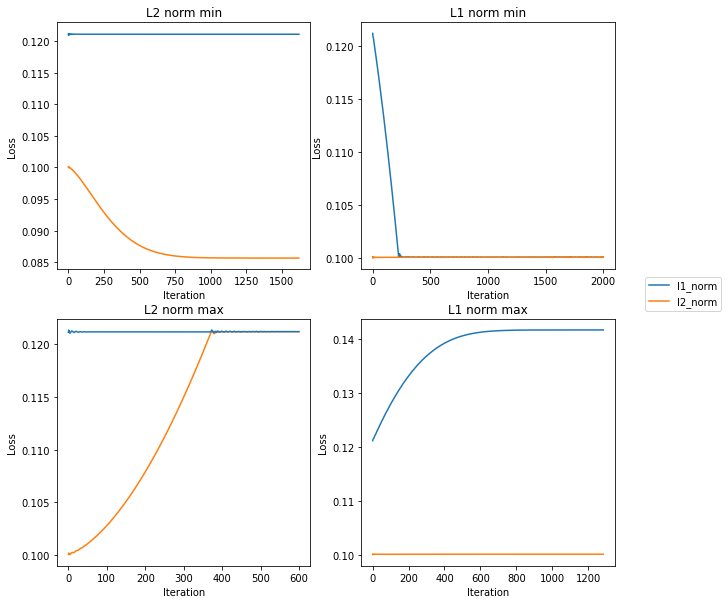

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
pal = {'l1_norm': 'C0', 'l2_norm': 'C1'}
for ax, (k, mad) in zip(axes.flatten(), all_mad.items()):
    ax.plot(mad.synthesis_metric_loss, pal[mad.synthesis_metric.__name__], label=mad.synthesis_metric.__name__)
    ax.plot(mad.fixed_metric_loss, pal[mad.fixed_metric.__name__], label=mad.fixed_metric.__name__)
    ax.set(title=k.capitalize().replace('_', ' '), xlabel='Iteration', ylabel='Loss')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 1.1))

This looks pretty good -- the L1 norm line is flat in the left column, while the L2 norm is flat in the right column, and the other line is either rising (in the bottom row) or falling (in the top).

Since our images only have two pixels, we can get a better sense of what's going on by plotting them in pixel space: first pixel value on the x-axis, second on the y-axis. We can use this to visualize the points and how far they are from each other. We also know what the level curves look like for the $L_1$ and $L_2$ norms (a diamond and a circle centered on our reference image, respectively), so we can add them as well.

In [4]:
l1 = to_numpy(torch.norm(all_mad['l2_norm_max'].reference_signal - all_mad['l2_norm_max'].initial_signal, 1))
l2 = to_numpy(torch.norm(all_mad['l2_norm_max'].reference_signal - all_mad['l2_norm_max'].initial_signal, 2))
ref = to_numpy(all_mad['l2_norm_max'].reference_signal.squeeze())
init = to_numpy(all_mad['l2_norm_max'].initial_signal.squeeze())

def circle(origin, r, n=1000):
    theta = 2*np.pi/n*np.arange(0, n+1)
    return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])
def diamond(origin, r, n=1000):
    theta = 2*np.pi/n*np.arange(0, n+1)
    rotation = np.pi/4
    square_correction = (np.abs(np.cos(theta-rotation)-np.sin(theta-rotation)) + np.abs(np.cos(theta-rotation)+np.sin(theta-rotation)))
    square_correction /= square_correction[0]
    r = r / square_correction
    return np.array([origin[1]+r*np.cos(theta), origin[0]+r*np.sin(theta)])
l2_level_set = circle(ref, l2,)
l1_level_set = diamond(ref, l1)

We can see in the following plot that it is doing the right thing, but it's very hard to separate these two metrics. We've styled the points below so that their color matches the contour level they're supposed to lie on (i.e., the fixed metric), and so that a hollow point shows the target was to minimize, and a solid one to maximize.

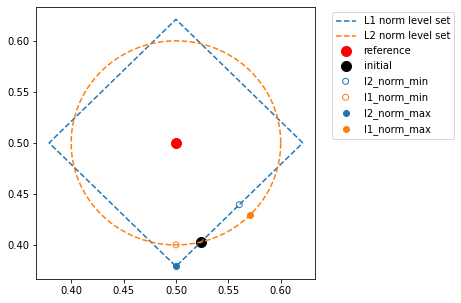

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*ref, label='reference', c='r', s=100)
ax.scatter(*init, label='initial', c='k', s=100)
ax.plot(*l1_level_set, pal['l1_norm']+'--', label='L1 norm level set')
ax.plot(*l2_level_set, pal['l2_norm']+'--', label='L2 norm level set')
for k, v in all_mad.items():
    ec = pal[v.fixed_metric.__name__]
    fc = 'none' if 'min' in k else ec
    ax.scatter(*v.synthesized_signal.squeeze().detach(), fc=fc, ec=ec, label=k)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In the above plot, the red dot in the middle is our reference signal and the black dot shows the initial signal. The new points we synthesized will either have the same L1 or L2 norm distance with the reference signal as that initial signal (the other distance will be minimized or maximized). Let's look at the solid blue dot first: this point has had its L2-norm maximized, while holding the L1 norm constant. We can see, therefore, that it lies along the L1-norm level set (the diamond) while moving as far away from the red dot as possible, which puts it in the corner of the diamond. This means that one of the pixels has the same value as the reference, while the other is as different as possible. Note that the other corners of the diamond would work equally well, but our initial point put us closest to this one.

Conversely, the solid orange dot is maximizing L1 norm (and holding L2 norm constant), so it lies along the L2 norm level set while moving as far away from the red dot as possible, which puts it along a diagonal away from the red dot. This means that neither pixel has the same value as the reference, they're both an intermediate value that has the same absolute difference from the reference point, as we can verify below:

In [6]:
all_mad['l1_norm_max'].synthesized_signal - all_mad['l1_norm_max'].reference_signal

tensor([[[[ 0.0708, -0.0709]]]], grad_fn=<SubBackward0>)

Now, if we look at the hollow orange dot, which is minimizing L1 and holding L2 constant, we can see that it has similarly moved along the L1 level set but gotten as close to the reference as possible, which puts it "along the axis" with the solid blue dot, just closer. Therefore, it has one pixel whose value matches that of the reference, and the other that is as close to the reference value as possible. Analogous logic holds for the hollow blue dot.

Generally, you're working with metrics and signals where you can't make the above plot to double-check the performance of MAD. Unfortunately, you'll have to spend time playing with the various parameters in order to find what works best. The most important of these parameters is `metric_tradeoff_lambda`; you can see above that we set it to the very high value of `1e4` (if you try reducing this yourself, you'll see the fixed metric doesn't stay constant and the points in the bottom plot move towards the reference point in the center). In this case, all four values took the same value of `metric_tradeoff_lambda`, but in general that might not be true (for example, if one of your metrics returns much larger values than the other).

## Full images!

We can, however, extend this L1 and L2 example to full images. Let's give that a try on a checkerboard:

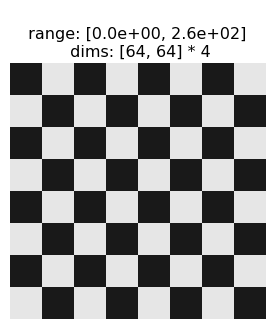

In [7]:
def create_checkerboard(image_size, period, values=[0, 1]):
    image = pt.synthetic_images.square_wave(image_size, period=period)
    image += pt.synthetic_images.square_wave(image_size, period=period, direction=np.pi/2)
    image += np.abs(image.min())
    image /= image.max()
    return torch.from_numpy(np.where((image < .75) & (image > .25), *values[::-1])).unsqueeze(0).unsqueeze(0).to(torch.float32)

# by setting the image to lie between 0 and 255 and be slightly within the max possible range, we make the optimizatio a bit easier.
img = 255 * create_checkerboard((64, 64), 16, [.1, .9])
po.imshow(img, vrange=(0, 255), zoom=4);
# you could also do this with another natural image, give it a try!

Now we'll do the same process of running synthesis and checking our loss as above:

In [8]:
def l1_norm(x, y):
    return torch.norm(x-y, 1)
metrics = [po.tools.optim.l2_norm, l1_norm]
tradeoffs = {'l2_norm_max': 1e-4, 'l2_norm_min': 1e-4,
             'l1_norm_max': 1e2, 'l1_norm_min': 1e3}

all_mad = {}

# this gets us all four possibilities
for t, (m1, m2) in itertools.product(['min', 'max'], zip(metrics, metrics[::-1])):
    name = f'{m1.__name__}_{t}'
    # we set the seed like this to ensure that all four MADCompetition instances have the same initial_signal. Try different seed values! 
    po.tools.set_seed(0)
    all_mad[name] = po.synth.MADCompetition(img, m1, m2, t, metric_tradeoff_lambda=tradeoffs[name], initial_noise=20, allowed_range=(0, 255), range_penalty_lambda=1)
    optim = torch.optim.Adam([all_mad[name].synthesized_signal], lr=.1)
    print(f"Synthesizing {name}")
    all_mad[name].synthesize(store_progress=True, max_iter=30000, optimizer=optim, stop_criterion=1e-10)

# double-check that these are all equal.
assert all([torch.allclose(all_mad['l2_norm_min'].initial_signal, v.initial_signal) for v in all_mad.values()])

Synthesizing l2_norm_min


  0%|          | 0/30000 [00:00<?, ?it/s]

Synthesizing l1_norm_min


  0%|          | 0/30000 [00:00<?, ?it/s]

Synthesizing l2_norm_max


  0%|          | 0/30000 [00:00<?, ?it/s]

Synthesizing l1_norm_max


  0%|          | 0/30000 [00:00<?, ?it/s]

We're going to visualize these slightly different to the above, since they have such different scales. The left axis shows the L1 norm loss, while the right one shows the L2 norm loss. Each of the four lines is a separate synthesis target, with the colors the same as above (note that `l1_norm_min` looks like it hasn't quite converged yet -- you can decrease the `stop_criterion` value and increase `max_iter` above to let it run longer, but the above is sufficient for demonstrative purposes).

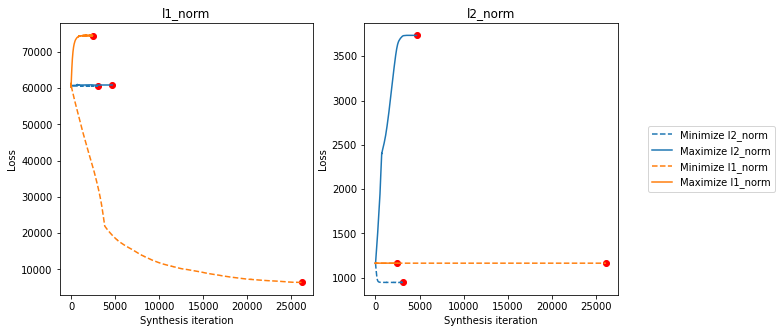

In [9]:
po.synth.mad_competition.plot_loss_all(*all_mad.values());

Now we'll show all the synthesized MAD images. In the following, the top row shows the reference and initial images, then the MAD images:

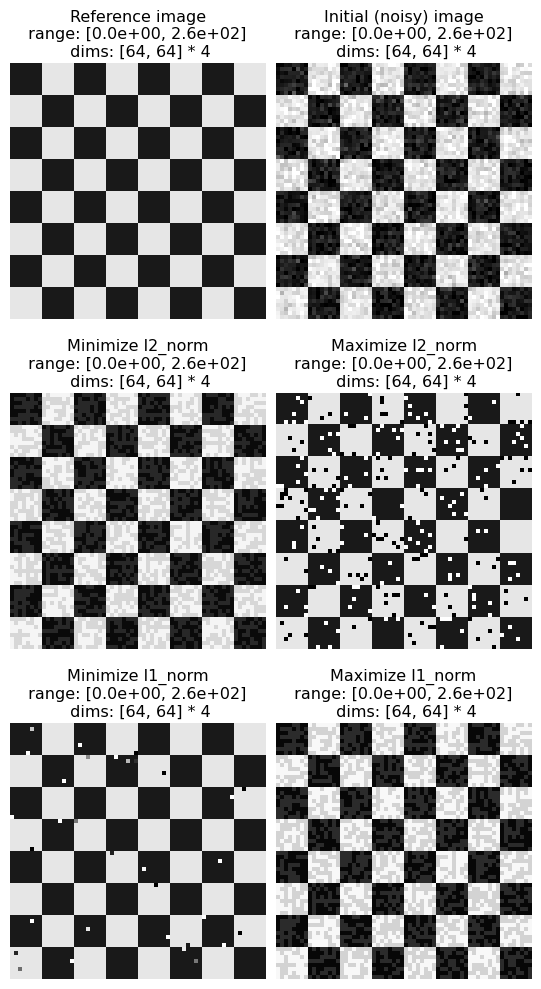

In [10]:
po.synth.mad_competition.display_synthesized_signal_all(*all_mad.values(), zoom=4, vrange=(0, 255));

If we go through them following the same logic as on the two-pixel case, we can see that our conclusions still hold. The following plots the difference between each of the above images and the reference image, to make the following points explicit:
- Max L2 and min L1 mainly have pixels that have the same value as the reference image, and the rest are all extremal values, as different from the reference as possible. Max L2 has more of these pixels, and they have more extremal values.
- Max L1 and min L2 pixels are all intermediate values, all the same absolute difference from the reference image. Max L1's absolute difference is larger than min L2's.

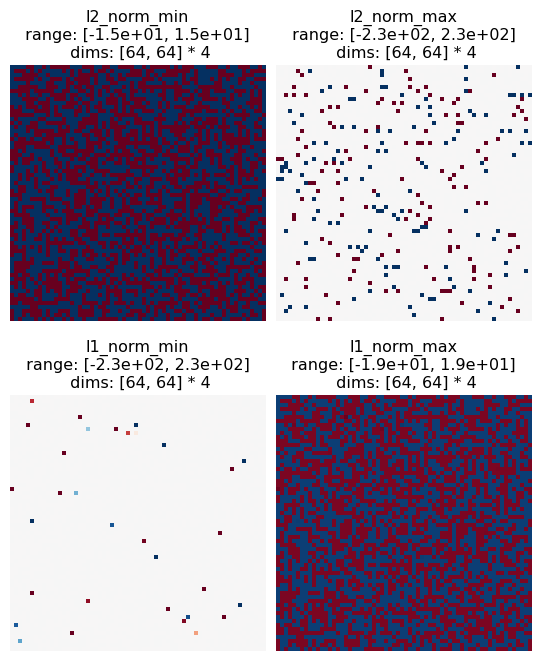

In [11]:
keys = ['l2_norm_min', 'l2_norm_max', 'l1_norm_min', 'l1_norm_max']
po.imshow([all_mad[k].synthesized_signal - all_mad[k].reference_signal for k in keys], title=keys,
          zoom=4, vrange='indep0', col_wrap=2);

Finally, to connect this to perception, this implies that L2 is a better perceptual metric than L1, as L2's two images are more perceptually distinct than L1's and the salt and pepper noise found in L2 max results in a perceptually worse image than the mid-level gray values found in L2 min (L1 makes the opposite prediction, that the mid-level gray values are perceptually worse than the salt and pepper noise). In order to validate this, you'd want to run a psychophysics experiment, but hopefully this simple example has helped show how MAD Competition can be used!